In [20]:
from scipy.stats import wasserstein_distance as wd



#Import everything
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import time
import glob
import pandas as pd
import seaborn as sns
import sys
from collections import defaultdict
from tqdm.notebook import tqdm
import matplotlib as mpl





def extract_file_data(df,columns):
    
    surface = df.sel(pressure=925.0)
        
    data = surface.to_dataframe()[columns]
    
    return data


 
def process_nc_file(fname,weights,true_latitude,columns):    
    
        #Get data 
        df = xr.open_dataset(fname)
        
        
        #Reset the latitude
        df = df.assign_coords(latitude=(true_latitude))
        

       
        #Get the data you want     
        grid_data = extract_file_data(df,columns)
        

        
        return grid_data

def process_directory(directory,weights,true_lat,columns):

    
    #Empty arrays to hold data
    dfs = []
    
    nc_files = sorted(glob.glob(directory+'/model_output*.nc')) #Dont process last file which is only super short
                
    for n in tqdm(nc_files): #for every model.nc file

        df_snapshot = process_nc_file(n,weights,true_lat,columns)
        dfs.append(df_snapshot)
        
    df = pd.concat(dfs,ignore_index=False)
    
    return df 


        
    
def get_global_weights():
    
     #Get the latitude weights from a special location
    r1 = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/Fig1_10year_Williams/'
    f = r1 + 'speedyoneWILLIAMS_L2_52_RN_10y/model_output00001.nc'
    df = xr.open_dataset(f)
    
    temp_file = df.temperature
    weights = np.cos(np.deg2rad(temp_file.latitude))
         
    weights.name = "weights"
    
    
    return weights, temp_file.latitude   


def compare_ensemble_against_control(control_dirs,competitor_dirs,columns):
    print ('STARTING!')
    
    
    #Get weights and correct latitudes now
    weights,latitude = get_global_weights()
    
    #Create an array that will hold all the data you are about
    lenT = 10
    out_array = np.zeros((lenT*len(control_dirs)*len(competitor_dirs),4))
    global_counter = 0
    
    for i in control_dirs:
        print ('Loading control data from', i)
        #Get the dataframe
        df_i = process_directory(i,weights,latitude,columns)
        #Get the dimensions: x,y,time
        long_idx = df_i.index.unique(level='longitude') #length 96
        lat_idx = df_i.index.unique(level='latitude') #length 48
        t_idx = df_i.index.unique(level='forecast_period') #length 3651

        
        ensemble_number_control = i.split('_m')[-1][0]

        #Convert to a numpy array
        np_control = np.array(df_i.values.reshape(len(long_idx),len(lat_idx),len(t_idx)))
        for j in tqdm(competitor_dirs):
            print ('Loading competitor data from', j)
            ensemble_number_competitor=j.split('_m')[-1][0]
                       
            #Get the competitor dataframe 
            df_j = process_directory(j,weights,latitude,columns)
            #...and also make this a numpy array
            np_competitor = np.array(df_j.values.reshape(len(long_idx),len(lat_idx),len(t_idx)))

            
            #Get the WD between i and j, averaged across every grid point, up to a time t
          
            for t in range(1,lenT+1):
                tfactor = int(t * len(t_idx)/lenT)
                #print(tfactor,t,len(t_idx),lenT)
                wasserstein_t_weighted = []
                wasserstein_t_unweighted = []
                for k in range(len(long_idx)):
                    for m in range(len(lat_idx)):
                        wasserstein= wd(np_competitor[k,m,0:tfactor], np_control[k,m,0:tfactor])
                        wasserstein_weighted = weights[m].values*wasserstein #Weight the value by the latitude weight


                        wasserstein_t_weighted.extend([wasserstein_weighted])
                        wasserstein_t_unweighted.extend([wasserstein])
                
                #Output to the global np array
                print(ensemble_number_control,ensemble_number_competitor,tfactor, np.mean(wasserstein_t_weighted))
                out_array[global_counter,:] = ensemble_number_control,ensemble_number_competitor,tfactor, np.mean(wasserstein_t_weighted)
                global_counter = global_counter +1
                
                
    return out_array
                
                        

columns = ['temperature']
root = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/10yearWD/'


control_dirs = []

for m in range(0,4+1):
    dir_name = root + f'backups/speedyone10yr_L2_52_RN_m{m}_WD'
    control_dirs.append(dir_name)
 


competitor_dirs = []
for m in range(5,9+1):
    dir_name = root + f'speedyone10yr_L2_52_RN_m{m}_WD'
    competitor_dirs.append(dir_name)
 
print ('List of control dirs:')
for i in control_dirs:
    print (i)
    
    
print ('List of competitor dirs:')
for i in competitor_dirs:
    print (i)
    
    
    
    
output = compare_ensemble_against_control(control_dirs,competitor_dirs,columns)
np.save(root+'52RN_WD.npy',output)




List of control dirs:
/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/10yearWD/backups/speedyone10yr_L2_52_RN_m0_WD
/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/10yearWD/backups/speedyone10yr_L2_52_RN_m1_WD
/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/10yearWD/backups/speedyone10yr_L2_52_RN_m2_WD
/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/10yearWD/backups/speedyone10yr_L2_52_RN_m3_WD
/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/10yearWD/backups/speedyone10yr_L2_52_RN_m4_WD
List of competitor dirs:
/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/10yearWD/speedyone10yr_L2_52_RN_m5_WD
/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/10yearWD/speedyone10yr_L2_52_RN_m6_WD
/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/10yearWD/speedyone10yr_L2_52_RN_m7_WD
/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/10year

  0%|          | 0/11 [00:00<?, ?it/s]

/home/k/kimpson/bin/conda/envs/workhorse/lib/python3.7/site-packages/scipy/io/netcdf.py:312: RuntimeWarning: Cannot close a netcdf_file opened with mmap=True, when netcdf_variables or arrays referring to its data still exist. All data arrays obtained from such files refer directly to data on disk, and must be copied before the file can be cleanly closed. (See netcdf_file docstring for more information on mmap.)
  ), category=RuntimeWarning)


  0%|          | 0/5 [00:00<?, ?it/s]

Loading competitor data from /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/10yearWD/speedyone10yr_L2_52_RN_m5_WD


  0%|          | 0/11 [00:00<?, ?it/s]

0 5 365 0.30883769059538263
0 5 730 0.28517268067452756
0 5 1095 0.2708314955950913
0 5 1460 0.26005210328626993
0 5 1825 0.2527390422459943
0 5 2190 0.24694922276408768
0 5 2555 0.24269097973496073
0 5 2920 0.2392884193998875
0 5 3285 0.23639589728273355
0 5 3651 0.23409552511537
Loading competitor data from /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/10yearWD/speedyone10yr_L2_52_RN_m6_WD


  0%|          | 0/11 [00:00<?, ?it/s]

0 6 365 0.29438894650570363
0 6 730 0.2702669293767241
0 6 1095 0.25584570434335824
0 6 1460 0.24496596031356757
0 6 1825 0.2376341414410032
0 6 2190 0.2315811172932415
0 6 2555 0.22714633997232736
0 6 2920 0.2232247592493471
0 6 3285 0.2204745005792053
0 6 3651 0.21774651726610544
Loading competitor data from /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/10yearWD/speedyone10yr_L2_52_RN_m7_WD


  0%|          | 0/11 [00:00<?, ?it/s]

0 7 365 0.28441004394948305
0 7 730 0.2601406271976994
0 7 1095 0.24532449583351085
0 7 1460 0.2352718895605036
0 7 1825 0.22821312043197123
0 7 2190 0.22291891619039778
0 7 2555 0.21870953800061388
0 7 2920 0.21553117300610422
0 7 3285 0.21257269772492846
0 7 3651 0.21024240431467853
Loading competitor data from /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/10yearWD/speedyone10yr_L2_52_RN_m8_WD


  0%|          | 0/11 [00:00<?, ?it/s]

0 8 365 0.29070345223223437
0 8 730 0.26746204921117717
0 8 1095 0.25344001138969857
0 8 1460 0.2438933238408804
0 8 1825 0.23706360975287863
0 8 2190 0.23158942367689436
0 8 2555 0.2272213813754231
0 8 2920 0.22357483342944676
0 8 3285 0.22041229028604398
0 8 3651 0.21772157781291085
Loading competitor data from /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/10yearWD/speedyone10yr_L2_52_RN_m9_WD


  0%|          | 0/11 [00:00<?, ?it/s]

0 9 365 0.2893155808842102
0 9 730 0.2638219563800519
0 9 1095 0.2493389666663666
0 9 1460 0.23828690256338547
0 9 1825 0.2308151973529274
0 9 2190 0.22475098373598656
0 9 2555 0.22072137424951638
0 9 2920 0.21711079758276153
0 9 3285 0.2144520971593533
0 9 3651 0.21192356064139328
Loading control data from /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/10yearWD/backups/speedyone10yr_L2_52_RN_m1_WD


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loading competitor data from /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/10yearWD/speedyone10yr_L2_52_RN_m5_WD


  0%|          | 0/11 [00:00<?, ?it/s]

1 5 365 0.2948732412551629
1 5 730 0.27221424533659394
1 5 1095 0.25739160112479736
1 5 1460 0.24704669402327165
1 5 1825 0.23968258933643563
1 5 2190 0.23402607080525062
1 5 2555 0.22996485376400383
1 5 2920 0.22675966652447613
1 5 3285 0.224075638147004
1 5 3651 0.2216965693099121
Loading competitor data from /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/10yearWD/speedyone10yr_L2_52_RN_m6_WD


  0%|          | 0/11 [00:00<?, ?it/s]

1 6 365 0.283223835049975
1 6 730 0.2598213700597347
1 6 1095 0.24554660179066592
1 6 1460 0.2357813009129065
1 6 1825 0.22892372176873974
1 6 2190 0.22387278545215905
1 6 2555 0.22002758495928967
1 6 2920 0.21676040055907564
1 6 3285 0.2139155586912601
1 6 3651 0.21106454908529734
Loading competitor data from /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/10yearWD/speedyone10yr_L2_52_RN_m7_WD


  0%|          | 0/11 [00:00<?, ?it/s]

1 7 365 0.29633681087811015
1 7 730 0.27225103988086397
1 7 1095 0.25691676930967744
1 7 1460 0.24585112574217038
1 7 1825 0.23810038618436913
1 7 2190 0.23247677151202584
1 7 2555 0.22826984450124715
1 7 2920 0.2249651590242241
1 7 3285 0.22234013824006615
1 7 3651 0.21978983552905232
Loading competitor data from /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/10yearWD/speedyone10yr_L2_52_RN_m8_WD


  0%|          | 0/11 [00:00<?, ?it/s]

1 8 365 0.2973248339686047
1 8 730 0.27349094697064036
1 8 1095 0.2590340397917872
1 8 1460 0.24890233979657475
1 8 1825 0.2414361074645244
1 8 2190 0.23590068241785833
1 8 2555 0.23164133622885597
1 8 2920 0.22823114919215381
1 8 3285 0.2253566304549754
1 8 3651 0.22281787961986557
Loading competitor data from /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/10yearWD/speedyone10yr_L2_52_RN_m9_WD


  0%|          | 0/11 [00:00<?, ?it/s]

1 9 365 0.29102288783225083
1 9 730 0.2668245127959978
1 9 1095 0.2513612817240728
1 9 1460 0.24084281530014728
1 9 1825 0.23291621397592696
1 9 2190 0.2271734648498717
1 9 2555 0.2227045832557912
1 9 2920 0.21929999669046152
1 9 3285 0.21631572087588719
1 9 3651 0.21383781117517695
Loading control data from /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/10yearWD/backups/speedyone10yr_L2_52_RN_m2_WD


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loading competitor data from /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/10yearWD/speedyone10yr_L2_52_RN_m5_WD


  0%|          | 0/11 [00:00<?, ?it/s]

2 5 365 0.28843405172707676
2 5 730 0.26524725592830944
2 5 1095 0.25064490944052475
2 5 1460 0.24101066673869168
2 5 1825 0.233630456097795
2 5 2190 0.22822829232802785
2 5 2555 0.22360524954780128
2 5 2920 0.2200647933098478
2 5 3285 0.21676616275468974
2 5 3651 0.21406491747546597
Loading competitor data from /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/10yearWD/speedyone10yr_L2_52_RN_m6_WD


  0%|          | 0/11 [00:00<?, ?it/s]

2 6 365 0.2877963413456142
2 6 730 0.26573940135458163
2 6 1095 0.25139304333209156
2 6 1460 0.2418850079694795
2 6 1825 0.23465231650250384
2 6 2190 0.2291438356484229
2 6 2555 0.2243724302522535
2 6 2920 0.2203619264348321
2 6 3285 0.21700733254690052
2 6 3651 0.2140566730006822
Loading competitor data from /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/10yearWD/speedyone10yr_L2_52_RN_m7_WD


  0%|          | 0/11 [00:00<?, ?it/s]

2 7 365 0.2910697790867146
2 7 730 0.2672367193874465
2 7 1095 0.2522353113462116
2 7 1460 0.24176673505993287
2 7 1825 0.23379373113180504
2 7 2190 0.22820854357178133
2 7 2555 0.22328701365844733
2 7 2920 0.21980814844158367
2 7 3285 0.21687794966756116
2 7 3651 0.21444806019620632
Loading competitor data from /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/10yearWD/speedyone10yr_L2_52_RN_m8_WD


  0%|          | 0/11 [00:00<?, ?it/s]

2 8 365 0.3028685228616911
2 8 730 0.27877976941219185
2 8 1095 0.26430043923194785
2 8 1460 0.25433331767823414
2 8 1825 0.2467741591833552
2 8 2190 0.24095839670919605
2 8 2555 0.23595634552503034
2 8 2920 0.23211900202207916
2 8 3285 0.22887513566742562
2 8 3651 0.2262824986629927
Loading competitor data from /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/10yearWD/speedyone10yr_L2_52_RN_m9_WD


  0%|          | 0/11 [00:00<?, ?it/s]

2 9 365 0.2872084153272596
2 9 730 0.2633985244695151
2 9 1095 0.24840550145763363
2 9 1460 0.23788747074226585
2 9 1825 0.2302805290129465
2 9 2190 0.22440927531271104
2 9 2555 0.219743510111856
2 9 2920 0.2162402760772414
2 9 3285 0.21307270628738395
2 9 3651 0.2105614825153757
Loading control data from /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/10yearWD/backups/speedyone10yr_L2_52_RN_m3_WD


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loading competitor data from /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/10yearWD/speedyone10yr_L2_52_RN_m5_WD


  0%|          | 0/11 [00:00<?, ?it/s]

3 5 365 0.2956006032675277
3 5 730 0.2733477815841192
3 5 1095 0.2584393789868563
3 5 1460 0.24840699885392498
3 5 1825 0.24107676008486947
3 5 2190 0.23551662760142028
3 5 2555 0.23116152721179192
3 5 2920 0.22764195260588138
3 5 3285 0.22458472193208667
3 5 3651 0.22204349152450767
Loading competitor data from /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/10yearWD/speedyone10yr_L2_52_RN_m6_WD


  0%|          | 0/11 [00:00<?, ?it/s]

3 6 365 0.297324549788649
3 6 730 0.2733545822902735
3 6 1095 0.259028664421542
3 6 1460 0.24827210251087609
3 6 1825 0.241094892286655
3 6 2190 0.23514481382347535
3 6 2555 0.23062440071216883
3 6 2920 0.2266169602015429
3 6 3285 0.22363826290099315
3 6 3651 0.2208001219186808
Loading competitor data from /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/10yearWD/speedyone10yr_L2_52_RN_m7_WD


  0%|          | 0/11 [00:00<?, ?it/s]

3 7 365 0.29474687427070356
3 7 730 0.27117009518613927
3 7 1095 0.25643952522205243
3 7 1460 0.24590106125279101
3 7 1825 0.23822540760219368
3 7 2190 0.23259570977980357
3 7 2555 0.22820920819060353
3 7 2920 0.22497380808005
3 7 3285 0.22225480094577424
3 7 3651 0.21985151362786542
Loading competitor data from /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/10yearWD/speedyone10yr_L2_52_RN_m8_WD


  0%|          | 0/11 [00:00<?, ?it/s]

3 8 365 0.30315996651358756
3 8 730 0.27926285921252814
3 8 1095 0.26530756713902764
3 8 1460 0.2549366796402892
3 8 1825 0.2479783989911431
3 8 2190 0.24252626967967078
3 8 2555 0.23840873189398432
3 8 2920 0.23475512786783298
3 8 3285 0.2320503091460347
3 8 3651 0.22954892102046565
Loading competitor data from /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/10yearWD/speedyone10yr_L2_52_RN_m9_WD


  0%|          | 0/11 [00:00<?, ?it/s]

3 9 365 0.2919498035784376
3 9 730 0.26845236123310406
3 9 1095 0.2538831757638566
3 9 1460 0.24356594459814238
3 9 1825 0.23635006215721063
3 9 2190 0.2307249471288301
3 9 2555 0.22666050343978295
3 9 2920 0.22338479225607402
3 9 3285 0.22070026017728323
3 9 3651 0.2181920647624244
Loading control data from /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/10yearWD/backups/speedyone10yr_L2_52_RN_m4_WD


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loading competitor data from /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/10yearWD/speedyone10yr_L2_52_RN_m5_WD


  0%|          | 0/11 [00:00<?, ?it/s]

4 5 365 0.2835934177154671
4 5 730 0.26086495175586877
4 5 1095 0.24632092739757283
4 5 1460 0.23643222243045559
4 5 1825 0.22955230441419383
4 5 2190 0.22445829162729153
4 5 2555 0.22045907979802098
4 5 2920 0.2175314735088578
4 5 3285 0.2147758749064952
4 5 3651 0.21246588839470754
Loading competitor data from /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/10yearWD/speedyone10yr_L2_52_RN_m6_WD


  0%|          | 0/11 [00:00<?, ?it/s]

4 6 365 0.30160157736236387
4 6 730 0.2787654881529997
4 6 1095 0.2645330511461248
4 6 1460 0.25505530938151694
4 6 1825 0.24809713768441602
4 6 2190 0.24258099223941995
4 6 2555 0.23803716029594776
4 6 2920 0.2344521598886215
4 6 3285 0.23150970591888045
4 6 3651 0.22887673143319187
Loading competitor data from /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/10yearWD/speedyone10yr_L2_52_RN_m7_WD


  0%|          | 0/11 [00:00<?, ?it/s]

4 7 365 0.28858636179191977
4 7 730 0.2652678987608452
4 7 1095 0.2509125747671658
4 7 1460 0.2410749363225863
4 7 1825 0.23423565159485094
4 7 2190 0.22907425991248256
4 7 2555 0.2251462997234085
4 7 2920 0.22220376402503483
4 7 3285 0.21975851650463799
4 7 3651 0.2174319726209587
Loading competitor data from /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/10yearWD/speedyone10yr_L2_52_RN_m8_WD


  0%|          | 0/11 [00:00<?, ?it/s]

4 8 365 0.29477702668482364
4 8 730 0.2721106887269231
4 8 1095 0.25778147181464345
4 8 1460 0.24845001694923236
4 8 1825 0.2419503827827116
4 8 2190 0.2370247910350408
4 8 2555 0.23296331864173433
4 8 2920 0.22970421169324565
4 8 3285 0.22652649037278433
4 8 3651 0.22380276943912547
Loading competitor data from /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/10yearWD/speedyone10yr_L2_52_RN_m9_WD


  0%|          | 0/11 [00:00<?, ?it/s]

4 9 365 0.2865001494145903
4 9 730 0.2621499748718572
4 9 1095 0.24612378134992388
4 9 1460 0.2352933582717093
4 9 1825 0.22746888829871892
4 9 2190 0.22189957788784243
4 9 2555 0.21723219099694535
4 9 2920 0.21390268194345732
4 9 3285 0.2109323052180026
4 9 3651 0.20856621138243345


# Process all ensemble members

In [21]:
data = np.load(root+'52RN_WD.npy')
   # p = f.split('/')[-1].split('.')[0]
df = pd.DataFrame({'Control': data[:, 0], 'Competitor': data[:, 1], 'Time':data[:, 2],'WD': data[:, 3]})
   # dfs.append(df)


In [22]:
df

,Control,Competitor,Time,WD
0,0.0,5.0,365.0,0.308838
1,0.0,5.0,730.0,0.285173
2,0.0,5.0,1095.0,0.270831
3,0.0,5.0,1460.0,0.260052
4,0.0,5.0,1825.0,0.252739
...,...,...,...,...
245,4.0,9.0,2190.0,0.221900
246,4.0,9.0,2555.0,0.217232
247,4.0,9.0,2920.0,0.213903
248,4.0,9.0,3285.0,0.210932


In [23]:
#Convert time to years
df['Time'] = df['Time'] / 365 

#Average over each competitor
dfmean = df.groupby(['Time']).mean().drop(['Control','Competitor'],axis=1)

#Plot it
#plot_WD(xmean,save=False,plot_error=False)

In [24]:
dfmean['precision'] = '52_RN'

In [25]:
def plot_WD(df):
    #Setup plot env
    #Setup plot env
    h,w = 12,12

    sns.set_theme(context='talk', 
                  style='ticks', 
                  palette='deep',
                  rc={'figure.figsize':(h,w)}
                  )

    

    
    fig, ax1 = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(h,w))
    

    p = sns.lineplot(data=df, x="Time", y="WD",hue="precision",ax=ax1,markers=True)

    #Config
    plt.subplots_adjust(wspace=0.1, hspace=0)

    ax1.set_ylabel("Wasserstein distance (K)")#, fontsize = 20)
    ax1.set_xlabel("Time (years)")#, fontsize = 20)
   

    ax1.set_yscale('log')
    ax1.set_xscale('log')
    
    #Other config
    ax1.legend().set_title(None)
   

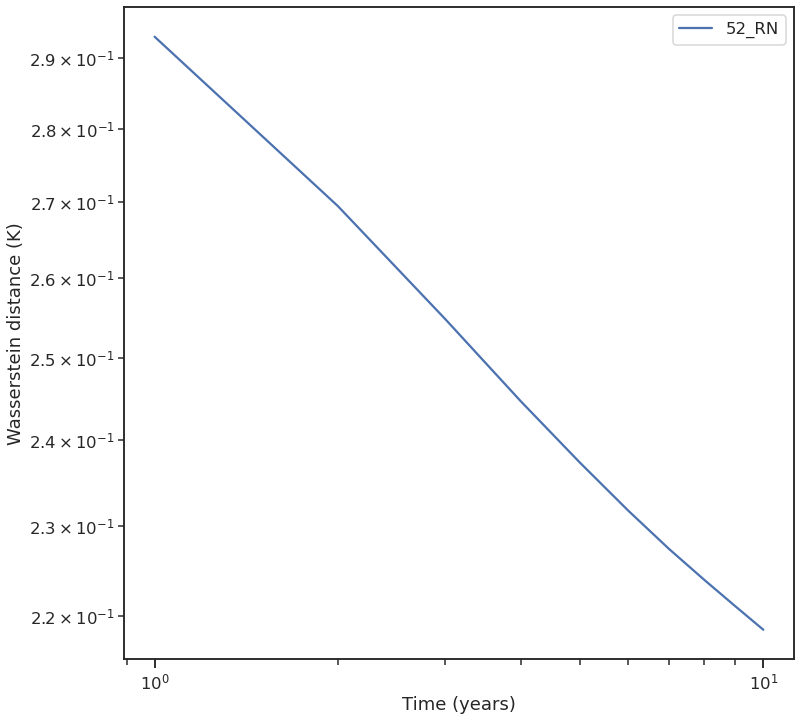

In [26]:
plot_WD(dfmean)